In [1]:
#import os
import netCDF4 as nc
import numpy as np
import glob
import datetime as dt

import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,10.)


In [2]:
DATA_DIR='/prj/GREENHOUSE/UKsitecomp/CHESS_runs/'
JULES_tag='JULES_v4.3_'
runs=['standard','TRIFFID_RsQ10']
profile='halfhourly'
file_res='yearly'
PLOT_DIR=DATA_DIR+'plots/'


In [3]:
site_name='Wytham Wood'
site_index=12
pft_index=0
soil_layer=0
start_year=2010
end_year=2012
variables=['gpp_gb','npp_gb','resp_p_gb','resp_s_gb',\
           'resp_l','resp_r','resp_w',               \
           'anetc','rdc','resp_p_g','resp_p_m',      \
           'tstar','t1p5m' ]


In [4]:
LC_inf=nc.Dataset(DATA_DIR+'chess_landcover_2000.nc','r')
landfrac=LC_inf.variables['frac'][:,site_index]
LC_inf.close()
print(landfrac)


[ 0.215     0.088125  0.3125    0.        0.33875   0.021875  0.02375   0.      ]


In [10]:
DataDict={ run : { var:{} for var in variables} for run in runs }

for run in runs:
    print(run)
    for year in range(start_year,end_year+1):
        print(year)
        infile=DATA_DIR+JULES_tag+run+'/'+JULES_tag+run+'.'+profile+'.'+str(year)+'.nc'
        inf=nc.Dataset(infile)
        if year==start_year:
            for var in variables:
                DataDict[run][var]['data']=inf.variables[var][...,site_index].squeeze()
                DataDict[run][var]['dims']=inf.variables[var].dimensions
                DataDict[run][var]['units']=inf.variables[var].units
            DataDict['latitude']=inf.variables['latitude'][0,site_index]
            DataDict['longitude']=inf.variables['longitude'][0,site_index]
            DataDict[run]['time']={'data':inf.variables['time'][:],    \
                              'units':inf.variables['time'].units }
        else:
            for var in variables:                
                DataDict[run][var]['data']=np.append(DataDict[run][var]['data'],\
                                                  inf.variables[var][...,site_index].squeeze(),\
                                                  axis=0)
            DataDict[run]['time']['data']=np.append(DataDict[run]['time']['data'], \
                                                 inf.variables['time'][:])
    
    DataDict[run]['time']['data']=np.round(DataDict[run]['time']['data']/1800.).astype('float64') \
                                    *1800.
    DataDict[run]['time']['object']=nc.num2date( DataDict[run]['time']['data'],       \
                                                units=DataDict[run]['time']['units'] )
    

standard
2010
2011
2012
TRIFFID_RsQ10
2010
2011
2012


In [11]:
for run in runs:
    for var in variables:
        if 'pft' in DataDict[run][var]['dims']:
            DataDict[run][var]['data']=np.sum(DataDict[run][var]['data']*landfrac[:5],axis=1)
        elif 'tile' in DataDict[run][var]['dims']:
            DataDict[run][var]['data']=np.sum(DataDict[run][var]['data']*landfrac,axis=1)
        elif 'soil' in DataDict[run][var]['dims']:
            DataDict[run][var]['data']=DataDict[run][var]['data'][:,soil_layer]
        elif ('scpool' in DataDict[run][var]['dims'])  & \
             (len(DataDict[run][var]['data'].shape)>1):
            DataDict[run][var]['data']=np.sum(DataDict[run][var]['data'],axis=1)
        

In [12]:
SmallDict={run:{var:DataDict[run][var]['data'] for var in variables} for run in runs}
DataFrame={run:pd.DataFrame(SmallDict[run],index=DataDict[run]['time']['object']) for run in runs}


In [ ]:
run='standard'
tmp=DataFrame[run].groupby(DataFrame[run].index.dayofyear).mean()
print(tmp.index)

In [ ]:
# conversion to gCO2 m^-2 hr^-1
units_conversion= (44.01/12.01) * 1e3 * 3600.
for run in runs:
    tmp=DataFrame[run].groupby(DataFrame[run].index.dayofyear).mean()
    dtindex=[dt.datetime.strptime('2000-'+doy,'%Y-%j') for doy in tmp.index.astype(str)]
    tmp.index=dtindex
    
    pltvars=['gpp_gb','npp_gb','resp_p_gb','resp_s_gb']
    (tmp[pltvars]*units_conversion).plot()
    plt.title('JULES-'+run+': Principal Components',fontsize=20)
    plt.ylabel('gCO2 m$^{-2}$ hr$^{-1}$',fontsize=20)
    plt.savefig(PLOT_DIR+run+'_PrincipalComponents.png')
    plt.show()
    
    pltvars=['resp_s_gb','resp_p_gb','resp_l','resp_r','resp_w','rdc']
    (tmp[pltvars]*units_conversion).plot()
    #temp=tmp['resp_l']+tmp['resp_w']+tmp['resp_r']+tmp['rdc']
    #(temp*units_conversion).plot()
    plt.title('JULES-'+run+': Respiration Components',fontsize=20)
    plt.ylabel('gCO2 m$^{-2}$ hr$^{-1}$',fontsize=20)
    plt.savefig(PLOT_DIR+run+'_RespirationComponents.png')
    plt.show()
    

In [ ]:
#Plot October Only
sp=273
ep=sp+31
# conversion to gCO2 m^-2 hr^-1
units_conversion= (44.01/12.01) * 1e3 * 3600.
for run in runs:
    tmp=DataFrame[run].groupby(DataFrame[run].index.dayofyear).mean()
    dtindex=[dt.datetime.strptime('2000-'+doy,'%Y-%j') for doy in tmp.index.astype(str)]
    tmp.index=dtindex
    #tmp['MinOfYear']=tmp.index.dayofyear+((tmp.index.hour+(tmp.index.minute/60.))/24.)
    #tmp=tmp.groupby(tmp['MinOfYear']).mean()
    
    pltvars=['gpp_gb','npp_gb','resp_p_gb','resp_s_gb']
    (tmp[pltvars][sp:ep]*units_conversion).plot()
    plt.title('JULES-'+run+': Principal Components - October',fontsize=20)
    plt.ylabel('gCO2 m$^{-2}$ hr$^{-1}$',fontsize=20)
    plt.savefig(PLOT_DIR+run+'_PrincipalComponents_October.png')
    plt.show()
    
    pltvars=['resp_s_gb','resp_p_gb','resp_l','resp_r','resp_w','rdc']
    (tmp[pltvars][sp:ep]*units_conversion).plot()
    plt.title('JULES-'+run+': Respiration Components - October',fontsize=20)
    plt.ylabel('gCO2 m$^{-2}$ hr$^{-1}$',fontsize=20)
    plt.savefig(PLOT_DIR+run+'_RespirationComponents_October.png')
    plt.show()
    

In [ ]:
#Plot October Only
# conversion to gCO2 m^-2 hr^-1
units_conversion= (44.01/12.01) * 1e3 * 3600.
for run in runs:    
    tmp=DataFrame[run][DataFrame[run].index.month==10].copy()
    tmp['Time']=tmp.index.map(lambda x: x.strftime("%H:%M"))
    tmp=tmp.groupby(tmp['Time']).mean()
    tmp.index=pd.to_datetime(tmp.index.astype(str))
    
    pltvars=['gpp_gb','npp_gb','resp_p_gb','resp_s_gb']
    (tmp[pltvars]*units_conversion).plot()
    plt.title('JULES-'+run+': Principal Components - OctoberDiurnal',fontsize=20)
    plt.ylabel('gCO2 m$^{-2}$ hr$^{-1}$',fontsize=20)
    plt.savefig(PLOT_DIR+run+'_PrincipalComponents_OctoberDiurnal.png')
    plt.show()
    
    pltvars=['resp_s_gb','resp_p_gb','resp_l','resp_r','resp_w','rdc']
    (tmp[pltvars]*units_conversion).plot()
    plt.title('JULES-'+run+': Respiration Components - October Diurnal',fontsize=20)
    plt.ylabel('gCO2 m$^{-2}$ hr$^{-1}$',fontsize=20)
    plt.savefig(PLOT_DIR+run+'_RespirationComponents_OctoberDiurnal.png')
    plt.show()
    

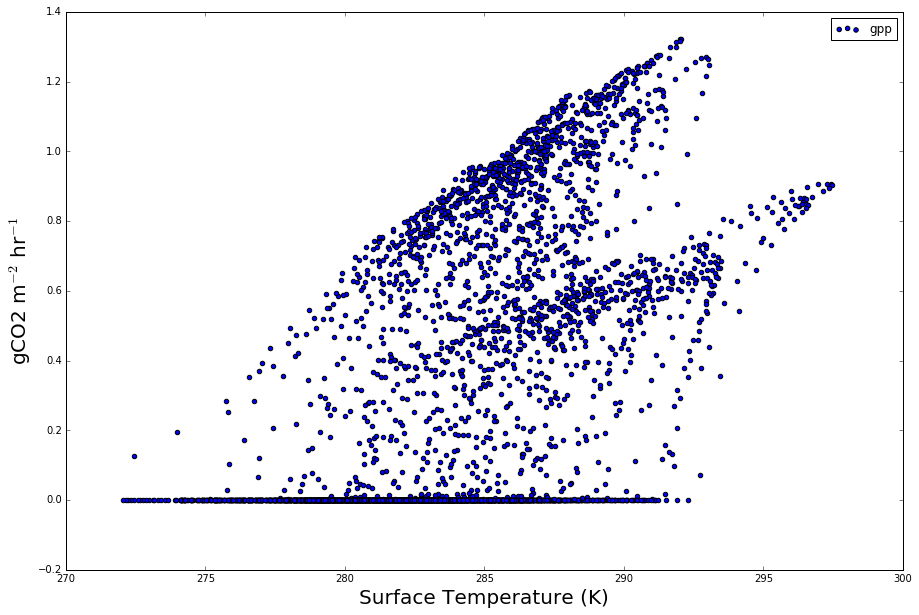

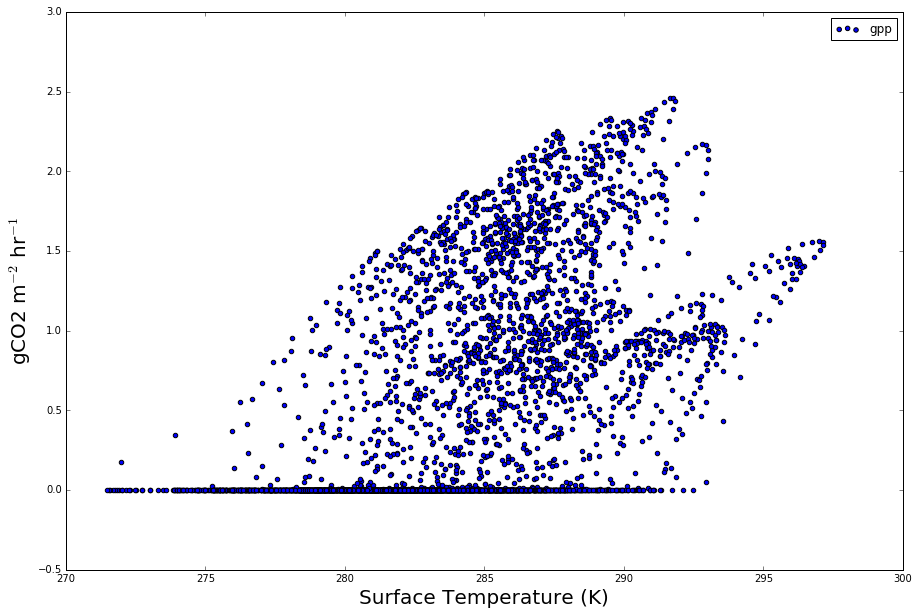

In [21]:
#Plot October Temperature Relationship
# conversion to gCO2 m^-2 hr^-1
units_conversion= (44.01/12.01) * 1e3 * 3600.

for run in runs:
    tmp=DataFrame[run][DataFrame[run].index.month==10].copy()
    plt.scatter(tmp['tstar'],tmp['gpp_gb']*units_conversion,label='gpp',c='b')
    #plt.scatter(tmp['tstar'],tmp['npp_gb']*units_conversion,label='npp',c='g')
    #plt.scatter(tmp['tstar'],tmp['resp_s_gb']*units_conversion,label='resp_s',c='r')
    #plt.scatter(tmp['tstar'],tmp['resp_p_gb']*units_conversion,label='resp_p',c='orange')
    plt.ylabel('gCO2 m$^{-2}$ hr$^{-1}$',fontsize=20)
    plt.xlabel('Surface Temperature (K)',fontsize=20)
    plt.title(run,font)
    plt.legend()
    plt.show()
